In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pulp
import re
%matplotlib inline



## Matchdata Reading from CSV File

In [39]:
matchdata=pd.read_csv('https://raw.githubusercontent.com/prakharmohan4/BYOP/main/IPL%20Ball-by-Ball%202008-2020.csv')

In [40]:
matchdata.head()

,id,inning,over,ball,batsman,non_striker,bowler,batsman_runs,extra_runs,total_runs,non_boundary,is_wicket,dismissal_kind,player_dismissed,fielder,extras_type,batting_team,bowling_team
0,335982,1,6,5,RT Ponting,BB McCullum,AA Noffke,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
1,335982,1,6,6,BB McCullum,RT Ponting,AA Noffke,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
2,335982,1,7,1,BB McCullum,RT Ponting,Z Khan,0,0,0,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
3,335982,1,7,2,BB McCullum,RT Ponting,Z Khan,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
4,335982,1,7,3,RT Ponting,BB McCullum,Z Khan,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore


## Aggregating Batsmen Data

In [41]:
        batsmen_score = pd.DataFrame(matchdata.groupby(['id', 'batsman'])['batsman_runs'].sum()).\
            rename(columns={"batsman_runs": "total_runs"})
        batsmen_scores_30 = pd.DataFrame(((matchdata.groupby(['id', 'batsman'])['batsman_runs'].sum())>=30).astype(int)).\
            rename(columns={"batsman_runs": "total_runs_30"})
        batsmen_scores_50 = pd.DataFrame(((matchdata.groupby(['id', 'batsman'])['batsman_runs'].sum())>=50).astype(int)).\
            rename(columns={"batsman_runs": "total_runs_50"})
        batsmen_scores_100 = pd.DataFrame(((matchdata.groupby(['id', 'batsman'])['batsman_runs'].sum())>=100).astype(int)).\
            rename(columns={"batsman_runs": "total_runs_100"})
        batsmen_scores_0 = pd.DataFrame(((matchdata.groupby(['id', 'batsman'])['batsman_runs'].sum())==0).astype(int)).\
            rename(columns={"batsman_runs": "total_runs_0"})
        batsmen_ball_faced = pd.DataFrame(matchdata.groupby(['id', 'batsman'])['over'].count()).\
            rename(columns={"over": "total_balls_faced"})
        batsmen_ball_faced_legal = pd.DataFrame(matchdata[matchdata['ball'] <=6].groupby(['id', 'batsman'])['ball'].count()).\
            rename(columns={"ball": "total_legal_balls_faced"})
        batsmen_scores6 = pd.DataFrame(matchdata[matchdata['batsman_runs'] == 6].groupby(['id', 'batsman'])['batsman_runs'].count()).\
            rename(columns={"batsman_runs": "run_6"})
        batsmen_scores4 = pd.DataFrame(matchdata[matchdata['batsman_runs'] == 4].groupby(['id', 'batsman'])['batsman_runs'].count()).\
            rename(columns={"batsman_runs": "run_4"})
        batsmen_position = pd.DataFrame(matchdata.groupby(['id', 'batsman'])['is_wicket'].min())
       
        
        df_list = [batsmen_score, batsmen_ball_faced, batsmen_ball_faced_legal, batsmen_scores6, batsmen_scores4, batsmen_position,batsmen_scores_30,batsmen_scores_50,batsmen_scores_100,batsmen_scores_0]
        batsmen_summary = pd.concat(df_list, join='outer', axis=1).fillna(np.nan).reset_index()
        batsmen_summary = pd.merge(batsmen_summary, matchdata[['id', 'batsman', 'inning', 'batting_team', 'bowling_team']].
                                   drop_duplicates(), on=['id', 'batsman'], how='left')
        batsmen_summary.rename(columns={'inning': 'batsmen_innings', 'batsman': 'playername', 'batting_team': 'PlayingTeam',
                                        'bowling_team': 'Opponent Team'}, inplace=True)

## Aggregating Bowler Data

In [42]:
        bowler_wickets = pd.DataFrame(matchdata[((matchdata['is_wicket'] == 1) & (~matchdata['dismissal_kind'].isin(['run out','retired hurt'])))].
                                      groupby(['id', 'bowler'])['is_wicket'].count()).\
            rename(columns={"is_wicket": "total_wickets"})
        bowler_overs_bow = pd.DataFrame(matchdata.groupby(['id', 'bowler'])['over'].count()).\
            rename(columns={"over": "total_balls_bowled"})
        bowler_ball_faced_legal = pd.DataFrame(matchdata[matchdata['ball'] <=6].groupby(['id', 'bowler'])['ball'].count()).\
            rename(columns={"ball": "total_legal_balls_bowled"})
        # calculating the number of maiden overs bowled in a match
        bowler_runs_given = pd.DataFrame(matchdata.groupby(['id', 'bowler'])['batsman_runs'].sum()).\
            rename(columns={"batsman_runs": "total_runs_given"})
        bowler_wickets_3 = pd.DataFrame((matchdata[((matchdata['is_wicket'] == 1) & (~matchdata['dismissal_kind'].isin(['run out','retired hurt'])))].
                                      groupby(['id', 'bowler'])['is_wicket'].count())==3).astype(int).\
            rename(columns={"is_wicket": "total_wickets_3"})
        bowler_wickets_4 = pd.DataFrame((matchdata[((matchdata['is_wicket'] == 1) & (~matchdata['dismissal_kind'].isin(['run out','retired hurt'])))].
                                      groupby(['id', 'bowler'])['is_wicket'].count())==4).astype(int).\
            rename(columns={"is_wicket": "total_wickets_4"})
        bowler_wickets_5 = pd.DataFrame((matchdata[((matchdata['is_wicket'] == 1) & (~matchdata['dismissal_kind'].isin(['run out','retired hurt'])))].
                                      groupby(['id', 'bowler'])['is_wicket'].count())==5).astype(int).\
            rename(columns={"is_wicket": "total_wickets_5"})
        bowler_maiden = pd.DataFrame(matchdata.groupby(['id', 'bowler', 'over'])['total_runs'].sum()).reset_index()
        bowler_maiden['maiden_overs'] = np.where(bowler_maiden['total_runs'] == 0, 1, 0)
        bowler_maiden = bowler_maiden.groupby(['id', 'bowler'])['maiden_overs'].sum()
        
        #legbyes to be considered
        
        df_list = [bowler_wickets, bowler_overs_bow, bowler_ball_faced_legal, bowler_runs_given,bowler_wickets_3,bowler_wickets_4,bowler_wickets_5,bowler_maiden]
        bowler_summary = pd.concat(df_list, join='outer', axis=1).fillna(np.nan).reset_index()
        # adding additional columns just in case we need for modeling
        bowler_summary = pd.merge(bowler_summary, matchdata[['id', 'bowler', 'inning', 'batting_team', 'bowling_team']].drop_duplicates(), on=['id', 'bowler'], how='left')
        bowler_summary.rename(columns={'inning': 'bowlers_innings', 'bowler': 'playername', 'batting_team': 'Playing team',
                                       'bowling_team': 'Opponent Team'}, inplace=True)
        bowler_summary['economy_rate'] = (bowler_summary['total_runs_given'] * 6) / bowler_summary['total_legal_balls_bowled']
        bowler_summary['eco less than 5'] = (bowler_summary['economy_rate']<=5).astype(int)
        bowler_summary['eco 5-5.99'] = ((bowler_summary['economy_rate']<6)&(bowler_summary['economy_rate']>=5)).astype(int)
        bowler_summary['eco 6-7'] = ((bowler_summary['economy_rate']>=6)&(bowler_summary['economy_rate']<7)).astype(int)
        bowler_summary['eco 7-10'] = ((bowler_summary['economy_rate']>=7)&(bowler_summary['economy_rate']<10)).astype(int)
        bowler_summary['eco 11-12'] = ((bowler_summary['economy_rate']>=11)&(bowler_summary['economy_rate']<12)).astype(int)
        bowler_summary['eco greater than 12'] = (bowler_summary['economy_rate']>12).astype(int)

## Merging Bowler and Batsmen Stats

In [43]:
ipl_merged_scorecard = pd.merge(batsmen_summary, bowler_summary, on=['id', 'playername'], how='outer')

## Performing Co-relation 

In [44]:
ipl_cor = ipl_merged_scorecard.copy()
ipl_cor.drop("id", axis=1, inplace=True)
ipl_cor.drop("playername", axis=1, inplace=True)


In [45]:
ipl_cor.fillna(value = 0,inplace = True)

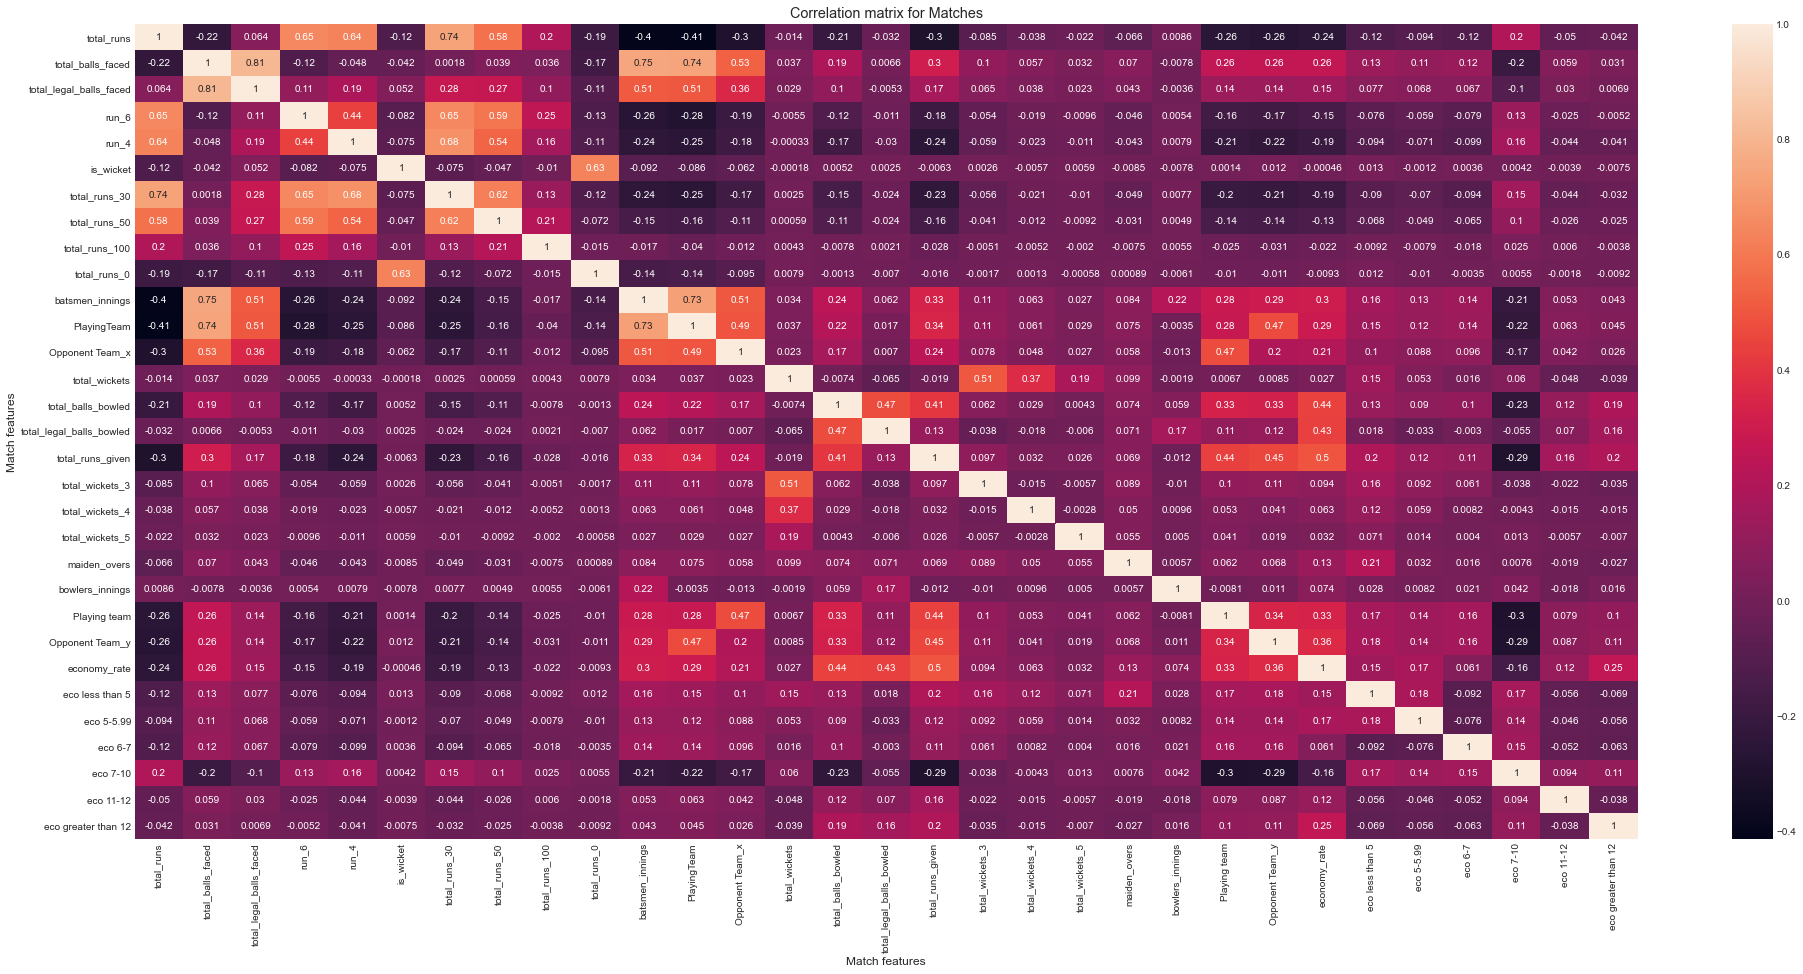

In [46]:
plt.figure(figsize=(30, 15))
correlation_matrix = ipl_cor.apply(lambda x: x.factorize()[0]).corr(method='pearson')
sns.heatmap(correlation_matrix, annot = True)
plt.title("Correlation matrix for Matches")
plt.xlabel("Match features")
plt.ylabel("Match features")
plt.show()

## Calculating Player Role

In [47]:
#All Rounder - If the Player has faced atleast 8 balls and bowled atleast 6 balls then he's an All rounder
#Bowler - If the Player has bowled more than 6 balls then he's a bowler 
# Batsem- If the Player has faced more than 8 balls then he's a batsmen (deafault) 

MINAVGBALLSFACED = 8
MINAVGBOWLSBOWLED = 6
player_avg = ipl_merged_scorecard[['playername', 'total_balls_faced', 'total_balls_bowled']].fillna(0)
player_avg = pd.DataFrame(player_avg.groupby('playername')[['total_balls_faced', 'total_balls_bowled']].mean())
conditions = [((player_avg['total_balls_faced'] >= MINAVGBALLSFACED) & (player_avg['total_balls_bowled'] >= MINAVGBOWLSBOWLED)),
              (player_avg['total_balls_bowled'] >= MINAVGBOWLSBOWLED)]
choices = ['AllRounder', 'Bowler']
player_avg['playing_role'] = np.select(conditions, choices, default='Batsmen')
player_avg = player_avg.reset_index()

In [48]:
player_avg

,playername,total_balls_faced,total_balls_bowled,playing_role
0,A Ashish Reddy,7.000000,9.642857,Bowler
1,A Chandila,0.583333,19.500000,Bowler
2,A Chopra,12.500000,0.000000,Batsmen
3,A Choudhary,4.000000,21.600000,Bowler
4,A Dananjaya,5.000000,25.000000,Bowler
...,...,...,...,...
575,YV Takawale,18.300000,0.000000,Batsmen
576,Yashpal Singh,16.750000,0.000000,Batsmen
577,Younis Khan,7.000000,0.000000,Batsmen
578,Yuvraj Singh,17.093023,6.837209,AllRounder


In [49]:
ipl_merged_scorecard = ipl_merged_scorecard.merge(player_avg[["playername","playing_role"]], how="inner",on="playername")


In [50]:
ipl_merged_scorecard

,id,playername,total_runs,total_balls_faced,total_legal_balls_faced,run_6,run_4,is_wicket,total_runs_30,total_runs_50,...,Playing team,Opponent Team_y,economy_rate,eco less than 5,eco 5-5.99,eco 6-7,eco 7-10,eco 11-12,eco greater than 12,playing_role
0,335982,AA Noffke,9.0,12.0,11.0,NaN,1.0,0.0,0.0,0.0,...,Kolkata Knight Riders,Royal Challengers Bangalore,8.750000,0.0,0.0,0.0,1.0,0.0,0.0,AllRounder
1,335982,B Akhil,0.0,2.0,2.0,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bowler
2,335985,B Akhil,3.0,6.0,6.0,NaN,NaN,0.0,0.0,0.0,...,Mumbai Indians,Royal Challengers Bangalore,5.666667,0.0,1.0,0.0,0.0,0.0,0.0,Bowler
3,335996,B Akhil,2.0,3.0,3.0,NaN,NaN,0.0,0.0,0.0,...,Chennai Super Kings,Royal Challengers Bangalore,8.500000,0.0,0.0,0.0,1.0,0.0,0.0,Bowler
4,336002,B Akhil,27.0,7.0,7.0,3.0,2.0,0.0,0.0,0.0,...,Deccan Chargers,Royal Challengers Bangalore,13.000000,0.0,0.0,0.0,0.0,0.0,1.0,Bowler
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17146,1216521,JR Hazlewood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Mumbai Indians,Chennai Super Kings,8.500000,0.0,0.0,0.0,1.0,0.0,0.0,Bowler
17147,1216533,JR Hazlewood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Rajasthan Royals,Chennai Super Kings,4.750000,1.0,0.0,0.0,0.0,0.0,0.0,Bowler
17148,1216539,JR Hazlewood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Delhi Capitals,Chennai Super Kings,6.750000,0.0,0.0,1.0,0.0,0.0,0.0,Bowler
17149,1216526,CJ Green,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Mumbai Indians,Kolkata Knight Riders,8.470588,0.0,0.0,0.0,1.0,0.0,0.0,Bowler


## Points Calculation

In [51]:
pointsconfig = {
        'total_runs': 1,
        'run_6': 2,
        'run_4': 1,
        '>=30':4,
        '>=50': 8,
        '>=100': 16,
        'duck': -2,
        'total_wickets': 25,
        '<=3W':4,
        '>=4W': 8,
        '>=5W': 16,
        'maiden_overs': 8,
        '<=5E': 6,
        '<6E': 4,
        '<7E': 2,
        '>10E': -2,
        '>11E': -4,
        '>12E': -6
    }

### Batsmen Points

In [52]:
        ipl_merged_scorecard['total_runs_points'] = ipl_merged_scorecard['total_runs'] * pointsconfig['total_runs']
        ipl_merged_scorecard['run_6_points'] = pointsconfig['run_6'] *  ipl_merged_scorecard['run_6']
        ipl_merged_scorecard['run_4_points'] = pointsconfig['run_4'] *  ipl_merged_scorecard['run_4']
        ipl_merged_scorecard['30_Run_Points'] = pointsconfig['>=30'] *  ipl_merged_scorecard['total_runs_30']
        ipl_merged_scorecard['50_Run_Points'] = pointsconfig['>=50'] *  ipl_merged_scorecard['total_runs_50']
        ipl_merged_scorecard['100_Run_Points'] = pointsconfig['>=100'] *  ipl_merged_scorecard['total_runs_100']
        ipl_merged_scorecard['duck_Points'] = pointsconfig['duck'] *  ipl_merged_scorecard['total_runs_0']
        ipl_merged_scorecard['total_bat_points'] = np.nan
        ipl_merged_scorecard['total_bat_points'] = ipl_merged_scorecard['total_runs_points'].add(ipl_merged_scorecard['run_6_points'], fill_value=0). \
            add(ipl_merged_scorecard['run_4_points'], fill_value=0).add(ipl_merged_scorecard['30_Run_Points'], fill_value=0).\
            add(ipl_merged_scorecard['50_Run_Points'], fill_value=0).add(ipl_merged_scorecard['100_Run_Points'], fill_value=0).\
            add(ipl_merged_scorecard['duck_Points'], fill_value=0)
        ipl_merged_scorecard['total_bat_points'] = np.where(ipl_merged_scorecard['total_balls_faced'] >= 1, ipl_merged_scorecard['total_bat_points'], np.nan)

### Bowler Points

In [53]:
        ipl_merged_scorecard['total_wicket_points'] = ipl_merged_scorecard['total_wickets'] * pointsconfig['total_wickets']
        ipl_merged_scorecard['<=5E_points'] = pointsconfig['<=5E'] *  ipl_merged_scorecard['eco less than 5']
        ipl_merged_scorecard['<6E_points'] = pointsconfig['<6E'] *  ipl_merged_scorecard['eco 5-5.99']
        ipl_merged_scorecard['<7E_points'] = pointsconfig['<7E'] *  ipl_merged_scorecard['eco 6-7']
        ipl_merged_scorecard['>10E_points'] = pointsconfig['>10E'] *  ipl_merged_scorecard['eco 7-10']
        ipl_merged_scorecard['>11E_points'] = pointsconfig['>11E'] *  ipl_merged_scorecard['eco 11-12']
        ipl_merged_scorecard['>12E_points'] = pointsconfig['>12E'] *  ipl_merged_scorecard['eco greater than 12']
        ipl_merged_scorecard['3W_points'] = pointsconfig['>=100'] *  ipl_merged_scorecard['total_wickets_3']
        ipl_merged_scorecard['4W_points'] = pointsconfig['>=100'] *  ipl_merged_scorecard['total_wickets_4']
        ipl_merged_scorecard['5W_points'] = pointsconfig['>=100'] *  ipl_merged_scorecard['total_wickets_5']
        ipl_merged_scorecard['maiden_overs_points'] = pointsconfig['>=100'] *  ipl_merged_scorecard['maiden_overs']
        ipl_merged_scorecard['total_bowl_points'] = np.nan
        ipl_merged_scorecard['total_bowl_points'] = ipl_merged_scorecard['total_wicket_points'].add(ipl_merged_scorecard['<=5E_points'], fill_value=0). \
            add(ipl_merged_scorecard['<6E_points'], fill_value=0).add(ipl_merged_scorecard['<7E_points'], fill_value=0).\
            add(ipl_merged_scorecard['>10E_points'], fill_value=0).add(ipl_merged_scorecard['>11E_points'], fill_value=0).\
            add(ipl_merged_scorecard['>12E_points'], fill_value=0).add(ipl_merged_scorecard['3W_points'], fill_value=0).\
            add(ipl_merged_scorecard['4W_points'], fill_value=0).add(ipl_merged_scorecard['5W_points'], fill_value=0).\
            add(ipl_merged_scorecard['maiden_overs_points'], fill_value=0)
        ipl_merged_scorecard['total_bowl_points'] = np.where(ipl_merged_scorecard['total_balls_bowled'] >= 1, ipl_merged_scorecard['total_bowl_points'], np.nan)

### Merging Bowler and Batsmen Points

In [54]:
ipl_merged_scorecard['total_points'] = ipl_merged_scorecard['total_bat_points'].add(ipl_merged_scorecard['total_bowl_points'], fill_value=0)

### Dropping Irrelevant Columns

In [57]:
ipl_merged_scorecard.drop(['id','PlayingTeam','Opponent Team_x','Playing team','Opponent Team_y'],axis=1,inplace=True)

In [58]:
ipl_merged_scorecard.columns

Index(['playername', 'total_runs', 'total_balls_faced',
       'total_legal_balls_faced', 'run_6', 'run_4', 'is_wicket',
       'total_runs_30', 'total_runs_50', 'total_runs_100', 'total_runs_0',
       'batsmen_innings', 'total_wickets', 'total_balls_bowled',
       'total_legal_balls_bowled', 'total_runs_given', 'total_wickets_3',
       'total_wickets_4', 'total_wickets_5', 'maiden_overs', 'bowlers_innings',
       'economy_rate', 'eco less than 5', 'eco 5-5.99', 'eco 6-7', 'eco 7-10',
       'eco 11-12', 'eco greater than 12', 'playing_role', 'total_runs_points',
       'run_6_points', 'run_4_points', '30_Run_Points', '50_Run_Points',
       '100_Run_Points', 'duck_Points', 'total_bat_points',
       'total_wicket_points', '<=5E_points', '<6E_points', '<7E_points',
       '>10E_points', '>11E_points', '>12E_points', '3W_points', '4W_points',
       '5W_points', 'maiden_overs_points', 'total_bowl_points',
       'total_points'],
      dtype='object')

### Null Value Treatment 

In [59]:
#ipl_merged_scorecard.replace([np.inf, -np.inf], np.nan, inplace=True)
ipl_merged_scorecard.fillna(0,inplace=True)

### One hot Encoding for playing_role

In [60]:
one_hot = pd.get_dummies(ipl_merged_scorecard['playing_role'],drop_first=True)
 #Drop column as it is now encoded
ipl_merged_scorecard = ipl_merged_scorecard.drop('playing_role',axis = 1)
#Join the encoded df


In [61]:
ipl_merged_scorecard = ipl_merged_scorecard.join(one_hot)


### Scaling

In [62]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
ipl_merged_scorecard.columns
features_to_scale = ['total_runs', 'total_balls_faced', 'total_legal_balls_faced', 'run_6',
       'run_4', 'total_wickets',
       'total_balls_bowled', 'total_legal_balls_bowled', 'total_runs_given',
        'economy_rate']
ipl_merged_scorecard[features_to_scale] = scaler.fit_transform(ipl_merged_scorecard[features_to_scale])

### Rearranging Columns

In [63]:
ipl_merged_scorecard= ipl_merged_scorecard[['playername','total_runs', 'total_balls_faced', 'total_legal_balls_faced', 'run_6',
       'run_4', 'is_wicket', 'total_runs_30', 'total_runs_50',
       'total_runs_100', 'total_runs_0', 'batsmen_innings', 'total_wickets',
       'total_balls_bowled', 'total_legal_balls_bowled', 'total_runs_given',
       'total_wickets_3', 'total_wickets_4', 'total_wickets_5', 'maiden_overs',
       'bowlers_innings', 'economy_rate', 'eco less than 5', 'eco 5-5.99',
       'eco 6-7', 'eco 7-10', 'eco 11-12', 'eco greater than 12',
       'Bowler', 'Batsmen','total_points']]

In [64]:
df1=ipl_merged_scorecard.copy()

In [65]:
from sklearn.model_selection import train_test_split

In [66]:
from sklearn.linear_model import LinearRegression

In [67]:
ipl_merged_scorecard.playername.value_counts().sort_values(ascending=False)

RG Sharma               194
SK Raina                189
V Kohli                 185
RV Uthappa              182
MS Dhoni                182
                       ... 
Sunny Gupta               1
PSP Handscomb             1
MA Wood                   1
X Thalaivan Sargunam      1
S Midhun                  1
Name: playername, Length: 580, dtype: int64

### Removing players who have played less than 5 matches

In [68]:
df = ipl_merged_scorecard.groupby('playername').filter(lambda x : len(x)>5)
df.head(20)

,playername,total_runs,total_balls_faced,total_legal_balls_faced,run_6,run_4,is_wicket,total_runs_30,total_runs_50,total_runs_100,...,economy_rate,eco less than 5,eco 5-5.99,eco 6-7,eco 7-10,eco 11-12,eco greater than 12,Bowler,Batsmen,total_points
1,B Akhil,-0.703760,-0.671338,-0.664906,-0.449268,-0.607954,0.0,0.0,0.0,0.0,...,-0.983609,0.0,0.0,0.0,0.0,0.0,0.0,1,0,-2.0
2,B Akhil,-0.552848,-0.381977,-0.366074,-0.449268,-0.607954,0.0,0.0,0.0,0.0,...,0.252257,0.0,1.0,0.0,0.0,0.0,0.0,1,0,57.0
3,B Akhil,-0.603152,-0.598997,-0.590198,-0.449268,-0.607954,0.0,0.0,0.0,0.0,...,0.870190,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0.0
4,B Akhil,0.654448,-0.309636,-0.291366,2.147472,0.343938,0.0,0.0,0.0,0.0,...,1.851613,0.0,0.0,0.0,0.0,0.0,1.0,1,0,29.0
5,B Akhil,-0.452240,-0.526657,-0.515490,-0.449268,-0.132008,0.0,0.0,0.0,0.0,...,0.252257,0.0,1.0,0.0,0.0,0.0,0.0,1,0,10.0
6,B Akhil,-0.552848,-0.598997,-0.590198,-0.449268,-0.607954,0.0,0.0,0.0,0.0,...,0.390383,0.0,0.0,1.0,0.0,0.0,0.0,1,0,5.0
7,B Akhil,-0.401936,-0.309636,-0.291366,-0.449268,-0.132008,0.0,0.0,0.0,0.0,...,-0.111233,1.0,0.0,0.0,0.0,0.0,0.0,1,0,13.0
8,B Akhil,-0.251024,-0.164956,-0.216658,-0.449268,-0.132008,0.0,0.0,0.0,0.0,...,-0.983609,0.0,0.0,0.0,0.0,0.0,0.0,1,0,10.0
9,B Akhil,-0.301328,-0.454317,-0.515490,0.416312,-0.607954,0.0,0.0,0.0,0.0,...,0.761143,0.0,0.0,0.0,1.0,0.0,0.0,1,0,33.0
10,B Akhil,-0.703760,-0.671338,-0.739614,-0.449268,-0.607954,0.0,0.0,0.0,0.0,...,-0.547421,1.0,0.0,0.0,0.0,0.0,0.0,1,0,4.0


### LR Model Fitting

In [69]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

models={}

for i in df['playername'].unique():
    X = df[df['playername']==i].drop(columns=['total_points','playername'])
    y=df[df['playername']==i]['total_points']
    X_train, X_test, y_train, y_test=train_test_split(X,y, random_state = 42,  test_size=0.25)
    lr = LinearRegression().fit(X_train,y_train)
    models[i]=lr

### Prediction

In [70]:
def prediction(playername):

    X = df[df['playername']==playername].drop(columns=['total_points','playername'])
    y = df[df['playername']==playername]['total_points']

    X_train, X_test, y_train, y_test=train_test_split(X,y, random_state = 42,  test_size=0.25)

    y_pred = models[playername].predict(X_test)
    
    return X_train, X_test, y_train, y_test, y_pred

In [73]:
# Prediction of Points for a particular player

player = input("Enter a player name: ")
X_train, X_test, y_train,y_test, y_pred = prediction(player)
print("\nActual Points\n", y_test)
print("\n\nPredicted Points\n", y_pred)


Actual Points
 10     4.0
12    25.0
1     -2.0
14    56.0
Name: total_points, dtype: float64


Predicted Points
 [11.66645999 21.4436269   9.43909604 49.6560273 ]


### MODEL EVALUATION FOR EACH PLAYERS INDIVIDUALLY

In [74]:
def errors_each_player(y_test, y_pred):
    r2 = r2_score(y_test , y_pred) 
    mse = mean_squared_error(y_test , y_pred) 
    rmse = np.sqrt(mean_squared_error(y_test , y_pred))
    mae = mean_absolute_error(y_test , y_pred) 
    return r2, mse, rmse, mae

Train Dataset Score: 1.0
Test Dataset Score: 1.0

 ---------------------------------------------------------------------------------------------------- 


R2 Score:  1.0
MSE:  7.205556213936196e-27
RMSE:  8.488554773302812e-14
MAE:  7.128104253423132e-14

 ---------------------------------------------------------------------------------------------------- 




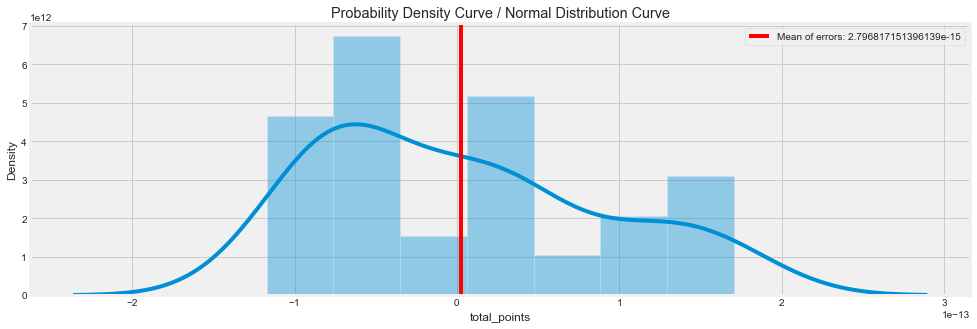


 ---------------------------------------------------------------------------------------------------- 




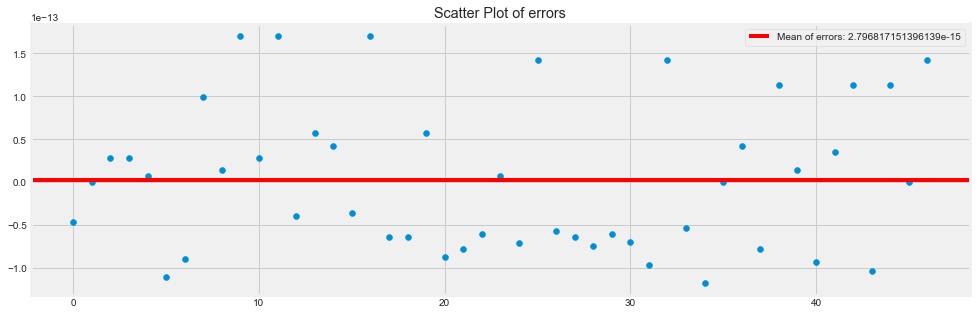


 ---------------------------------------------------------------------------------------------------- 


Summary Report
 --------------------------------------------------                             OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.831e+29
Date:                Sun, 03 Jul 2022   Prob (F-statistic):               0.00
Time:                        23:37:20   Log-Likelihood:                 3873.1
No. Observations:                 138   AIC:                            -7698.
Df Residuals:                     114   BIC:                            -7628.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                               coef  

In [76]:
# Evaluation of model performance for a particular player
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

def model_evaluation(playername):

    X_train, X_test, y_train, y_test, y_pred = prediction(playername)
    errors = y_test - y_pred

    if input("View scores? Enter Y or N : ").upper() == "Y":
        print("Train Dataset Score:", models[playername].score(X_train, y_train))
        print("Test Dataset Score:", models[playername].score(X_test, y_test))
        print("\n","-" * 100,"\n\n")

    if input("View errors? Enter Y or N : ").upper() == "Y":

        r2, mse, rmse, mae = errors_each_player(y_test, y_pred)
        print( "R2 Score: ", r2 )
        print( "MSE: ", mse )
        print( "RMSE: ", rmse )
        print( "MAE: ", mae )
        print("\n","-" * 100,"\n\n")

    if input("View Normal Distribution Curve of errors? Enter Y or N : ").upper() == "Y":

        plt.figure(figsize=(15,5))
        sns.distplot(errors, bins = "sturges")
        plt.axvline(x = errors.mean() , color ="r", label = f"Mean of errors: {errors.mean()}")
        plt.title("Probability Density Curve / Normal Distribution Curve")
        plt.legend()
        plt.show()
        print("\n","-" * 100,"\n\n")

    if input("View Scatter Plot of errors? Enter Y or N : ").upper() == "Y":
        plt.figure(figsize=(15,5))
        plt.scatter(range(len(y_test)), errors)
        plt.axhline(y = errors.mean() , color ="r", label = f"Mean of errors: {errors.mean()}")
        plt.title("Scatter Plot of errors")
        plt.legend()
        plt.show()
        print("\n","-" * 100,"\n\n")

    if input("View Summary report? Enter Y or N : ").upper() == "Y":
        # y = m1x1 + m2x2+ ... + c
        x_train_2 = sm.add_constant(X_train)
        ols = sm.OLS(y_train, x_train_2).fit()
        print("Summary Report\n", "-"*50 , ols.summary())
        print("\n","-" * 100,"\n\n")

    if input("View VIF? Enter Y or N : ").upper() == "Y":
        # VIF dataframe
        vif_data = pd.DataFrame()
        vif_data["feature"] = X_train.columns
        
        # calculating VIF for each feature
        vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                                for i in range(len(X_train.columns))]
        
        print(vif_data)
        

player = input("Enter a player name: ")
model_evaluation(player)

### EVALUATION FOR ALL PLAYERS TOGETHER

Weighted Errors and R2 Score:

Weighted R2 Score for ALL players:  7.014015868069439
Weighted MSE for ALL players:  160.2498250571688
Weighted RMSE for ALL players:  19.855669297932817
Weighted MAE for ALL players:  10.855077413986205

 ---------------------------------------------------------------------------------------------------- 


RESIDUAL ANALYSIS

 ---------------------------------------------------------------------------------------------------- 




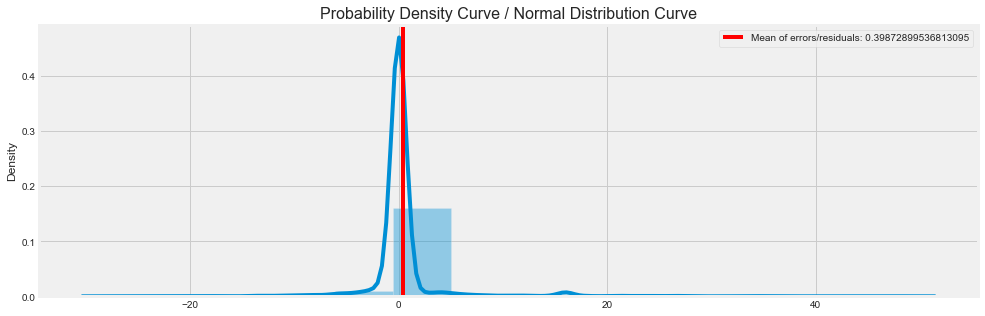


 ---------------------------------------------------------------------------------------------------- 




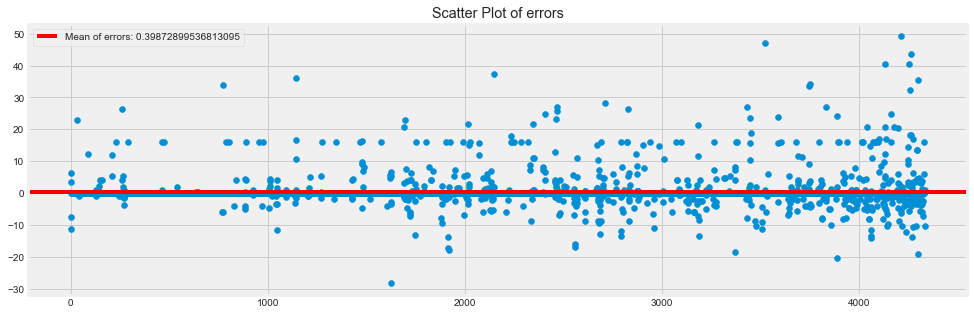


 ---------------------------------------------------------------------------------------------------- 




In [78]:
# Evaluation for ALL PLAYERS

# Weighted average of errors and r2 score for ALL players

weighted_r2_total = 0
weighted_mse_total = 0
weighted_rmse_total = 0
weighted_mae_total = 0

residual_all_players = []

for i in df['playername'].unique():
    # Predictions for EACH player
    X_train, X_test, y_train, y_test, y_pred = prediction(i)

    # Calculating r2 and errors for EACH player
    r2, mse, rmse, mae = errors_each_player(y_test, y_pred)

    # Calculating the WEIGHTED SUM of r2 and errors
    weighted_r2_total = weighted_r2_total + r2 * len(y_test)
    weighted_mse_total = weighted_mse_total + mse * len(y_test)
    weighted_rmse_total = weighted_rmse_total + rmse * len(y_test)
    weighted_mae_total = weighted_mae_total + mae * len(y_test)

    # Calculating the residuals for EACH player
    residual = y_test - y_pred

    # Appending each players residuals to the list
    residual_all_players = residual_all_players + list(residual.values)


# Calculating the r2 and errors for the entire model
total_num_of_players = len(df['playername'].unique())

weighted_r2 = weighted_r2_total / total_num_of_players
weighted_mse = weighted_mse_total / total_num_of_players
weighted_rmse = weighted_rmse_total / total_num_of_players
weighted_mae = weighted_mae_total / total_num_of_players

print("Weighted Errors and R2 Score:\n")
print("Weighted R2 Score for ALL players: ", weighted_r2)
print("Weighted MSE for ALL players: ", weighted_mse)
print("Weighted RMSE for ALL players: ", weighted_rmse)
print("Weighted MAE for ALL players: ", weighted_mae)
print("\n","-" * 100,"\n\n")

print("RESIDUAL ANALYSIS")
print("\n","-" * 100,"\n\n")

plt.figure(figsize=(15,5))
sns.distplot(residual_all_players, bins = "sturges")
plt.axvline(x = np.mean(residual_all_players) , color ="r", label = f"Mean of errors/residuals: {np.mean(residual_all_players)}")
plt.title("Probability Density Curve / Normal Distribution Curve", fontsize = 16)
plt.legend()
plt.show()
print("\n","-" * 100,"\n\n")


plt.figure(figsize=(15,5))
plt.scatter(range(len(residual_all_players)), residual_all_players)
plt.axhline(y = np.mean(residual_all_players) , color ="r", label = f"Mean of errors: {np.mean(residual_all_players)}")
plt.title("Scatter Plot of errors")
plt.legend()
plt.show()
print("\n","-" * 100,"\n\n")

### Preparing Data for LPP

In [80]:
new= pd.DataFrame()
new['playername'] = df['playername'].unique()
new['y_pred'] = [prediction(i)[4] for i in df['playername'].unique()]
new

,playername,y_pred
0,B Akhil,"[11.66645999188351, 21.443626901814035, 9.4390..."
1,BB McCullum,"[7.999999999999998, 19.999999999999993, 0.9999..."
2,CL White,"[69.08374723800019, 98.00000000000004, 102.000..."
3,DJ Hussey,"[12.999999999999964, 118.00000000000009, 8.999..."
4,JH Kallis,"[22.99999999999999, 7.000000000000028, 35.0000..."
...,...,...
408,P Amarnath,"[23.61881838324103, 15.329267760241452]"
409,AM Salvi,"[25.468463139925447, 0.38468298462695216]"
410,Anand Rajan,"[3.1036144774650936, 25.0785948082413]"
411,BW Hilfenhaus,"[23.000000000000014, 48.00000000000003, 34.999..."


In [81]:
new=new.merge(player_avg,on='playername')

In [83]:
new.drop(['total_balls_faced','total_balls_bowled'],axis=1,inplace=True)

### Input Dataframe

In [84]:
inputdf=pd.read_csv('https://raw.githubusercontent.com/prakharmohan4/BYOP/main/inputfile.csv')

In [85]:
inputdf=inputdf.merge(new,how='left')

In [86]:
inputdf

,playername,playing_team,y_pred,playing_role
0,AM Rahane,MI,"[46.999999999999986, 95.99999999999997, 15.000...",Batsmen
1,AR Patel,DC,"[37.00000000000001, 44.000000000000014, 22.999...",Bowler
2,HH Pandya,MI,"[55.00000000000029, 20.000000000000064, 17.000...",AllRounder
3,Ishan Kishan,MI,"[33.99999999999999, 24.99999999999999, 4.99999...",Batsmen
4,KA Pollard,MI,"[21.000000000000043, 2.9999999999999254, 25.00...",AllRounder
5,KH Pandya,MI,"[111.00000000000007, 57.999999999999964, 1.000...",AllRounder
6,MP Stoinis,DC,"[129.0000000000001, 126.0000000000001, 54.0000...",AllRounder
7,Q de Kock,MI,"[0.9999999999999645, 7.999999999999972, 1.9999...",Batsmen
8,RG Sharma,MI,"[2.0000000000000533, 19.000000000000075, 20.00...",Batsmen
9,RR Pant,DC,"[7.000000000000018, 7.000000000000023, 5.00000...",Batsmen


### Creating Dummy Variables

In [87]:
def get_dummies(data, col_names = ["playing_role", "playing_team"]):
    dummies_data = pd.get_dummies(inputdf, columns=["playing_role", "playing_team"])
    return dummies_data

In [88]:
finaldf = get_dummies(inputdf)

In [89]:
finaldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 0 to 21
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   playername               22 non-null     object
 1   y_pred                   22 non-null     object
 2   playing_role_AllRounder  22 non-null     uint8 
 3   playing_role_Batsmen     22 non-null     uint8 
 4   playing_role_Bowler      22 non-null     uint8 
 5   playing_team_DC          22 non-null     uint8 
 6   playing_team_MI          22 non-null     uint8 
dtypes: object(2), uint8(5)
memory usage: 638.0+ bytes


### Computing Weighted Average

In [100]:
def compute_weighted_points(points_vector, alpha = 0.20):
    weights = np.exp(list(reversed(np.array(range(1, len(points_vector)+1))*alpha * -1)))
    exponential_weighted_average = np.average(np.array(points_vector),weights=weights)
    return exponential_weighted_average

In [101]:
finaldf['predicted_points'] = finaldf['y_pred'].apply(compute_weighted_points)
finaldf.reset_index(inplace = True)
display(finaldf[['playername', 'y_pred', 'predicted_points']].head())

,playername,y_pred,predicted_points
0,AM Rahane,"[46.999999999999986, 95.99999999999997, 15.000...",29.423008
1,AR Patel,"[37.00000000000001, 44.000000000000014, 22.999...",30.599715
2,HH Pandya,"[55.00000000000029, 20.000000000000064, 17.000...",31.802127
3,Ishan Kishan,"[33.99999999999999, 24.99999999999999, 4.99999...",29.067513
4,KA Pollard,"[21.000000000000043, 2.9999999999999254, 25.00...",20.682615


### Linear Programming Problem

In [102]:
max_players = 11
max_batsman = 5
max_allrounders = 3
max_bowlers = 5
max_team1_players = 7
max_team2_players = 7

In [103]:
prob = pulp.LpProblem('Dreamteam', pulp.LpMaximize)

### Decision Variables

In [104]:
decision_variables = []

for rownum, row in finaldf.iterrows():
    variable = str('x_{}'.format(str(rownum)))
    variable = pulp.LpVariable(variable, lowBound = 0, upBound = 1, cat = 'Integer' ) 
    decision_variables.append(variable)
    
print(decision_variables)

[x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_10, x_11, x_12, x_13, x_14, x_15, x_16, x_17, x_18, x_19, x_20, x_21]


In [105]:
print(finaldf.columns)
total_points = ''
for rownum, row in finaldf.iterrows():
    formula = row['predicted_points'] * decision_variables[rownum]
    total_points+= formula
prob += total_points

Index(['level_0', 'index', 'playername', 'y_pred', 'playing_role_AllRounder',
       'playing_role_Batsmen', 'playing_role_Bowler', 'playing_team_DC',
       'playing_team_MI', 'predicted_points'],
      dtype='object')


### Defining Constraints for Dream11 Team

In [106]:
total_batsman = ''
total_allrounder = ''
total_bowler = ''
total_players = ''
total_team2 = ''
total_team1 = ''

for rownum, row in finaldf.iterrows():
    batsman_formula = row['playing_role_Batsmen'] * decision_variables[rownum]
    total_batsman += batsman_formula
    
    allrounder_formula = row['playing_role_AllRounder'] * decision_variables[rownum]
    total_allrounder+=allrounder_formula
    
    bowler_formula = row['playing_role_Bowler']*decision_variables[rownum]
    total_bowler += bowler_formula
    
    total_players_formula = decision_variables[rownum]
    total_players += total_players_formula
    
    formula = row['playing_team_DC']*decision_variables[rownum]
    total_team1 += formula
    
    formula = row['playing_team_MI']*decision_variables[rownum]
    total_team2 += formula
    

prob += (total_batsman <= max_batsman)
prob += (total_allrounder <= max_allrounders)
prob += (total_bowler <= max_bowlers)
prob += (total_players == max_players)
prob += (total_team1 <= max_team1_players)
prob += (total_team2 <= max_team2_players)



print(prob)
prob.writeLP('Dreamteam.lp')

optimization_result = prob.solve()

Dreamteam:
MAXIMIZE
29.42300819902534*x_0 + 30.599715315967508*x_1 + 54.18430238502345*x_10 + 39.77364238441541*x_11 + 20.376645610212062*x_12 + 45.6044519311028*x_13 + 29.893137448528996*x_14 + 7.802125439867067*x_15 + 41.954658484878166*x_16 + 63.62378973438104*x_17 + 24.459512649849636*x_18 + 20.191035384287844*x_19 + 31.802127219887335*x_2 + 25.72811749794624*x_20 + 17.84811195455807*x_21 + 29.067513280813255*x_3 + 20.682615360286484*x_4 + 35.49061660887327*x_5 + 43.29341015377373*x_6 + 41.45134416598164*x_7 + 23.03195254875963*x_8 + 23.647749438372863*x_9 + 0.0
SUBJECT TO
_C1: x_0 + x_10 + x_11 + x_12 + x_13 + x_3 + x_7 + x_8 + x_9 <= 5

_C2: x_2 + x_4 + x_5 + x_6 <= 3

_C3: x_1 + x_14 + x_15 + x_16 + x_17 + x_18 + x_19 + x_20 + x_21 <= 5

_C4: x_0 + x_1 + x_10 + x_11 + x_12 + x_13 + x_14 + x_15 + x_16 + x_17 + x_18
 + x_19 + x_2 + x_20 + x_21 + x_3 + x_4 + x_5 + x_6 + x_7 + x_8 + x_9 = 11

_C5: x_1 + x_10 + x_12 + x_13 + x_14 + x_15 + x_17 + x_18 + x_19 + x_6 + x_9
 <= 7

_C6: x_

### Calculating Maximum Points

In [107]:
variable_name = []
variable_value = []

for v in prob.variables():
    variable_name.append(v.name)
    variable_value.append(v.varValue)
    
df = pd.DataFrame({'index': variable_name, 'value': variable_value})
for rownum, row in df.iterrows():
    value = re.findall(r'(\d+)', row['index'])
    df.loc[rownum, 'index'] = int(value[0])

df = df.sort_values(by = 'index')
result = pd.merge(finaldf, df, on = 'index')
result = result[result['value'] == 1].sort_values(by = 'predicted_points', ascending = False)
selected_cols_final = ['playername', 'playing_team_DC', 'playing_team_MI', 'predicted_points']
final_set_of_players_to_be_selected = result[selected_cols_final]

display(final_set_of_players_to_be_selected)

,playername,playing_team_DC,playing_team_MI,predicted_points
17,K Rabada,1,0,63.623790
10,S Dhawan,1,0,54.184302
13,SS Iyer,1,0,45.604452
6,MP Stoinis,1,0,43.293410
16,JJ Bumrah,0,1,41.954658
7,Q de Kock,0,1,41.451344
11,SA Yadav,0,1,39.773642
5,KH Pandya,0,1,35.490617
2,HH Pandya,0,1,31.802127
1,AR Patel,1,0,30.599715
